In [8]:
import pandas as pd
import os
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler
import math
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

import gc

import logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)-15s %(levelname)s: %(message)s')
logging.basicConfig(level=logging.INFO,
                    filename='./log.txt',
                    filemode='w',
                    format='%(asctime)s - %(filename)s[line:%(lineno)d] - %(levelname)s: %(message)s')


In [2]:
path = 'E:/Dataset/零基础入门金融风控-贷款违约预测'
train = pd.read_csv(path+'/train.csv')
# test = pd.read_csv(path+'/testA.csv')
train_new = train.drop(['id', 'issueDate', 'grade',
                      'subGrade','employmentLength', 'issueDate','earliesCreditLine'], axis=1)
train_new.fillna(0, inplace=True)
x_train_new = train_new.drop(['isDefault'], axis=1)
y_train_new = train['isDefault']
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train_new, y_train_new, random_state=42)

In [3]:
train_new.isna().sum()

loanAmnt              0
term                  0
interestRate          0
installment           0
employmentTitle       0
homeOwnership         0
annualIncome          0
verificationStatus    0
isDefault             0
purpose               0
postCode              0
regionCode            0
dti                   0
delinquency_2years    0
ficoRangeLow          0
ficoRangeHigh         0
openAcc               0
pubRec                0
pubRecBankruptcies    0
revolBal              0
revolUtil             0
totalAcc              0
initialListStatus     0
applicationType       0
title                 0
policyCode            0
n0                    0
n1                    0
n2                    0
n3                    0
n4                    0
n5                    0
n6                    0
n7                    0
n8                    0
n9                    0
n10                   0
n11                   0
n12                   0
n13                   0
n14                   0
dtype: int64

1. 回归任务中的加权平均法
pre = (pre1 + pre2 + pre3 +...+pren )/n
pre = 0.3pre1 + 0.3pre2 + 0.4pre3 
2. 分类算法中的投票
加权投票


In [4]:
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=42)
clf3 = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=4, min_child_weight=2, subsample=0.7,objective='binary:logistic')

clf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)])

train_new = train.drop(['id', 'issueDate', 'grade',
                      'subGrade','employmentLength', 'issueDate','earliesCreditLine'], axis=1)


clf.fit(x_train, y_train)
accuracy_score(y_test, clf.predict(x_test))

[10:09:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.80475

In [5]:
# 加权投票，这东西这么慢？
vclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('xgb', clf3)], voting='soft', weights=[2, 1, 1])
vclf.fit(x_train, y_train)
accuracy_score(y_test, vclf.predict(x_test))

[10:11:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.80403

ValueError: Filler values must be provided when X has more than 2 training features.

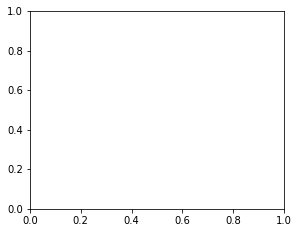

In [16]:
# stacking 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from mlxtend.classifier import StackingClassifier
import itertools
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions


clf1 = KNeighborsClassifier(n_neighbors=1)  # 这个鬼东西计算是不是会很慢
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()

sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], meta_classifier=lr)

label = ['KNN', 'Random Forest', 'Naive Bays', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]

fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1], repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
    scores = cross_val_score(clf, x_train, y_train, cv=5, scoring='accuracy')
    # print("Accuracy: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), label))
    logging.info("Accuracy: %.2f (+/- %.2f) [%s]" % (scores.mean(), scores.std(), label))
    
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
    
    clf.fit(x_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=x_train.values, y=y_train.values, clf=clf)
    plt.title(label)
plt.show()

In [15]:
logging.info('Test data to file: +/-0.2f')
logging.info('Test data to file: +/-0.3f')
logging.info('Test data to file: +/-0.4f')